In [75]:
import cv2,glob,time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
%matplotlib inline

In [54]:
#Load dataset here
#we use the Udacity provide dataset
vehicles = glob.glob('dataset/vehicles/vehicles/**/*.png')
unvehicles = glob.glob('dataset/non-vehicles/non-vehicles/**/*.png')

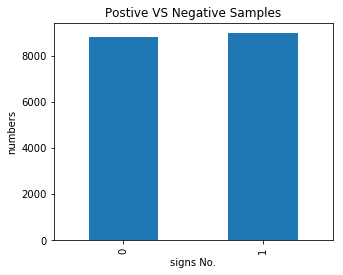

[8792, 8968]


In [103]:
#display the results
label = ['vehicles','unvehicles']
array = [len(vehicles),len(unvehicles)]
_nums_ = pd.Series.from_array(array)
plt.figure(figsize = (5,4))
fig = _nums_.plot(kind = 'bar')
fig.set_title('Postive VS Negative Samples')
fig.set_ylabel("numbers")
fig.set_xlabel("signs No.")
plt.show()
print(array)

In [56]:
#we can see the number of the Positive Samples is very close to the number of Negative samples,
#Visiulization the dataset for both Positive and Negative samples

In [57]:
#the size of each image(random choose 20 samples from whole dataset)
#here we find all 20 random sampled images are all 64*63*3 shapes
import random
for i in range(20):
    samples_idx = random.randint(0,len(vehicles))
    file_name = vehicles[samples_idx]
    #print(file_name)
    img = mpimg.imread(file_name)
    print(img.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


In [58]:
#scan whole postive & negative dataset, is all images are all the same shapes?
#postive data: 8792;  negative data: 8968
#all data are 64*64*3, they have same shapes, we need not scale them to same h,w
counter = 0
shapes = (64,64,3)
for i in range(8792):
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    if(img.shape == shapes):
        counter += 1
print('The total number of postive data shape(64,64,3) is',counter)
counter = 0
for i in range(8968):
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    if(img.shape == shapes):
        counter += 1
print('The total number of negative data shape(64,64,3) is',counter)

The total number of postive data shape(64,64,3) is 8792
The total number of negative data shape(64,64,3) is 8968


In [107]:
#random sample 45 images from vehicles/nonvehicles dataset, and visiulization them
def image_visiulization(is_vehicles = True):
    data = []
    if(is_vehicles):
        data = vehicles
    else:
        data = unvehicles
    plt.figure(figsize = (5,2), dpi = 160)
    for i in range(45):
        idx = random.randint(0,len(vehicles))
        ax = plt.subplot(3,15,i+1)
        ax.axis('off')
        file_name = data[idx]
        img = mpimg.imread(file_name)
        ax.imshow(img)
    plt.show()

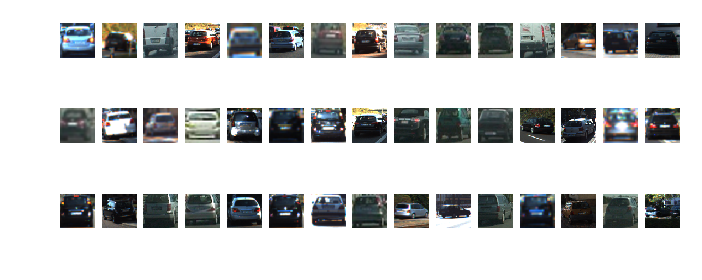

In [108]:
#vehicles dataset visiulization
image_visiulization(is_vehicles=True)

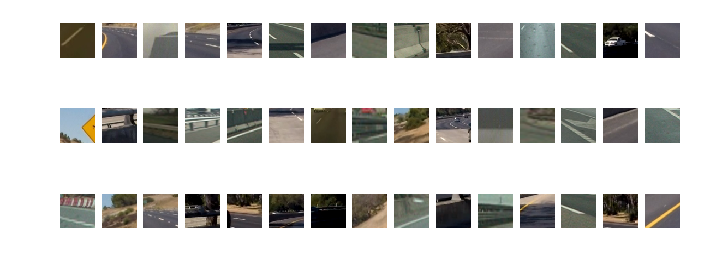

In [109]:
#nonvehicles dataset
image_visiulization(is_vehicles=False)

In [62]:
#Apply random brightness, contrast and saturation jitter in random order
#to our dataset, make the dataset more rubust

In [63]:
#This code moved from my CarND P2, the original code is copy from mxnet
def ColorJitterAug(img, brightness, contrast, saturation):
    """Apply random brightness, contrast and saturation jitter in random order"""
    coef = np.array([[[0.299, 0.587, 0.114]]])
    if brightness > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-brightness, brightness) * 0.7
        img *= alpha
        img = np.clip(img, 0.,255.)

    if contrast > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-contrast, contrast) * 0.7
        gray = img*coef
        gray = (3.0*(1.0-alpha)/gray.size)*np.sum(gray)
        img *= alpha
        img += gray
        img = np.clip(img, 0.,255.)

    if saturation > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-saturation, saturation) * 0.7
        gray = img*coef
        gray = np.sum(gray, axis=2, keepdims=True)
        gray *= (1.0-alpha)
        img *= alpha
        img += gray
        img = np.clip(img, 0.,255.)
    return img

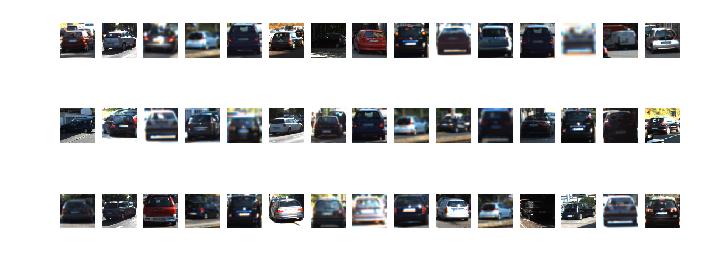

In [64]:
#apply the ColorJitterAug function to first 45 data, to see the different between original and new one
#we will apply this function later, before we start feature extract.
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    ax.imshow(img)
plt.show()

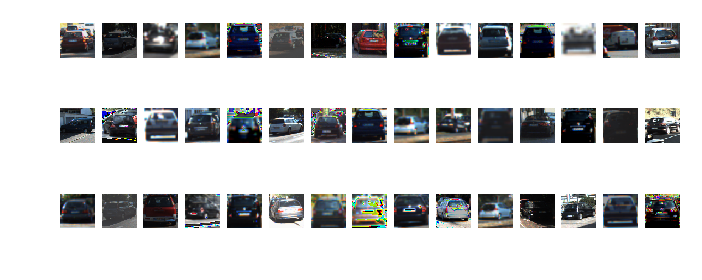

In [65]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    ax.imshow(generate_image)
plt.show()

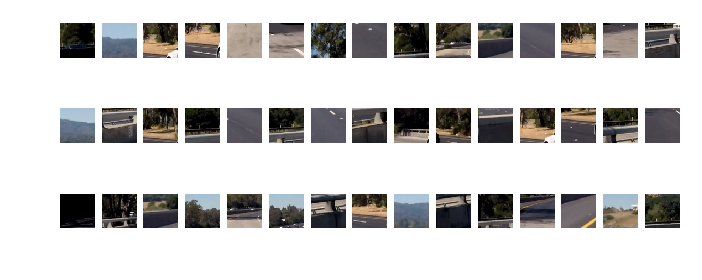

In [66]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    ax.imshow(img)
plt.show()

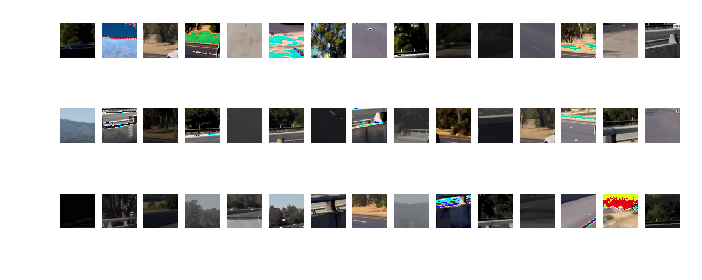

In [67]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    ax.imshow(generate_image)
plt.show()

In [68]:
#we can see, after we applied the ColorJitterAug function to our data can generate many low-quality data,
#if we applied those methods to our whole dataset, and using them to train our classifier may can make
#our classifier more rubust

In [69]:
#Now, apllied ColorJitterAug to our dataset, before we using it, we should read all dataset from lists
#the dataset is too small, so we just read them to our ram, need not create imdb to store the data
pos_data = []
for i in range(len(vehicles)):
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    pos_data.append(img)
print(np.array(pos_data).shape)
neg_data = []
for i in range(len(unvehicles)):
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    neg_data.append(img)
print(np.array(neg_data).shape)

(8792, 64, 64, 3)
(8968, 64, 64, 3)


In [70]:
#apply ColorJitterAug function to pos_data/neg_data
for i in range(len(vehicles)):
    img = np.array(pos_data[i])
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    pos_data.append(generate_image)
print(np.array(pos_data).shape)

for i in range(len(unvehicles)):
    img = np.array(neg_data[i])
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    neg_data.append(generate_image)
print(np.array(neg_data).shape)

(17584, 64, 64, 3)
(17936, 64, 64, 3)


In [71]:
#because the positive and negative data is too close, so I am not doing like project2 to balanced the data;

In [ ]:
#defined feature extract methods:hog here
#hog_channel 0: channel 0; 1: channel 1; 2: channel 2; others: all channel

In [96]:
def hog_extract(img, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2), 
                visualise=False, transform_sqrt=False, feature_vector=True, 
                normalise=None, hog_channel = 0):
    flag = 0
    if(hog_channel == 0):
        img = img[:,:,0]
    elif(hog_channel == 1):
        img = img[:,:,1]
    elif(hog_channel == 2):
        img = img[:,:,2]
    else:
        flag = 1
    if flag==1:
        features = []
        for i in range(3):
            feature = hog( img[:,:,i], orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, visualise=False, 
                        transform_sqrt=transform_sqrt, feature_vector=feature_vector, 
                        normalise=normalise)
            features.append(feature)
        features = np.ravel(features)
        return features
            
    if visualise:
        features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                                  cells_per_block=cells_per_block, visualise=visualise, 
                                  transform_sqrt=transform_sqrt, feature_vector=feature_vector, 
                                  normalise=normalise)
        return features, hog_image
    else:
        features = hog( img, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, visualise=visualise, 
                        transform_sqrt=transform_sqrt, feature_vector=feature_vector, 
                        normalise=normalise)
        return features

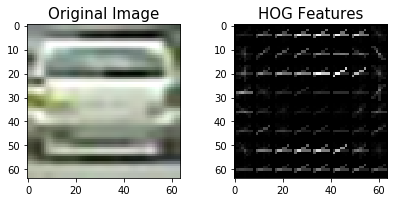

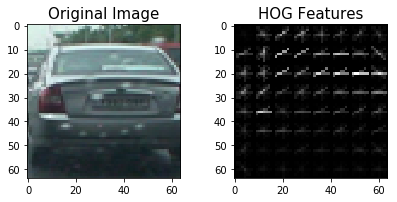

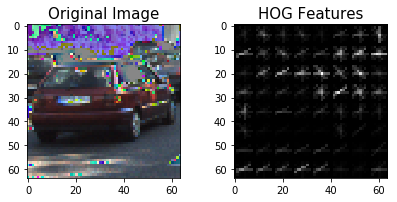

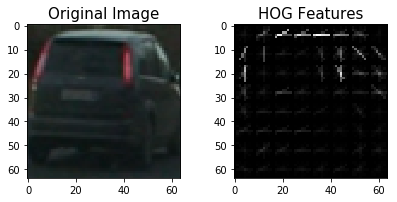

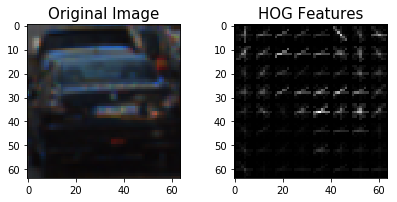

In [102]:
#display 5 postive examples within hog features
for i in range(5):
    idx = random.randint(0,len(pos_data))
    img = pos_data[idx]
    #print(img.shape)
    features, hog_img = hog_extract(img, visualise = True)
    #plt.imshow(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
    f.tight_layout()
    ax1.imshow(img)
    
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(hog_img, cmap = 'gray')
    ax2.set_title('HOG Features', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

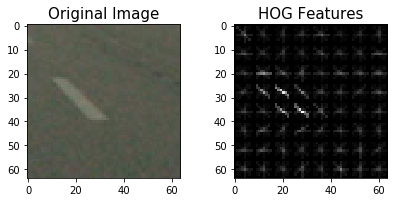

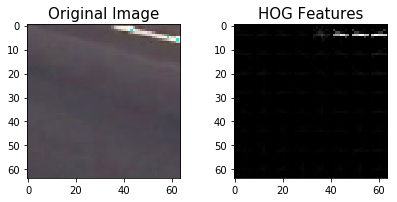

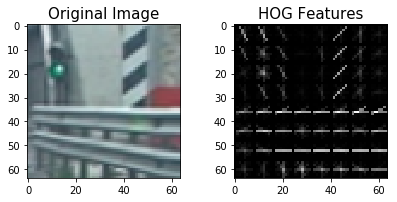

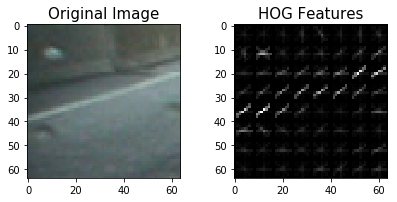

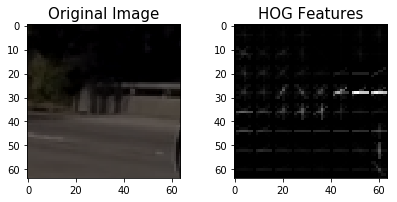

In [101]:
#display 5 negative examples within hog features
for i in range(5):
    idx = random.randint(0,len(pos_data))
    img = neg_data[idx]
    #print(img.shape)
    features, hog_img = hog_extract(img, visualise = True)
    #plt.imshow(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
    f.tight_layout()
    ax1.imshow(img)
    
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(hog_img, cmap = 'gray')
    ax2.set_title('HOG Features', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#defined color transform methods:i.e. GRAY, YUV, HSV, LUV, HLS, etc.

In [95]:
def color_transform(img, cmd = 'RGB'):
    if cmd == 'RGB':
        return img
    elif cmd == 'HSV':
        HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype("float")
        return HSV
    elif cmd == 'LUV':
        LUV = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype("float")
        return LUV
    elif cmd == 'GRAY':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype("float")
        return gray
    elif cmd == 'HLS':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
        return hls
    elif cmd == 'YUV':
        yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype("float")
        return yuv
    else:
        raise NotImplementedError

In [ ]:
#doing feature extract under different channel images

In [112]:
#RGB R,G,B,and ALL
import time
t = time.time()
pos_r = [hog_extract(pos_data[i], hog_channel = 0) for i in range(len(pos_data))]
print('extract r channel cost',time.time()-t)
print(np.array(pos_r).shape)
t = time.time()
pos_g = [hog_extract(pos_data[i], hog_channel = 1) for i in range(len(pos_data))]
print('extract g channel cost',time.time()-t)
print(np.array(pos_g).shape)
t = time.time()
pos_b = [hog_extract(pos_data[i], hog_channel = 2) for i in range(len(pos_data))]
print('extract b channel cost',time.time()-t)
print(np.array(pos_b).shape)
t = time.time()
pos_rgb = [hog_extract(pos_data[i], hog_channel = 3) for i in range(len(pos_data))]
print('extract all rgb channel cost',time.time()-t)
print(np.array(pos_rgb).shape)

extract r channel cost 14.288496494293213
(17584, 1568)
extract g channel cost 14.14698314666748
(17584, 1568)
extract b channel cost 14.2868070602417
(17584, 1568)
extract all rgb channel cost 42.83444571495056
(17584, 4704)


In [117]:
t = time.time()
neg_r = [hog_extract(neg_data[i], hog_channel = 0) for i in range(len(neg_data))]
print('extract r channel cost',time.time()-t)
print(np.array(neg_r).shape)
t = time.time()
neg_g = [hog_extract(neg_data[i], hog_channel = 1) for i in range(len(neg_data))]
print('extract g channel cost',time.time()-t)
print(np.array(neg_g).shape)
t = time.time()
neg_b = [hog_extract(neg_data[i], hog_channel = 2) for i in range(len(neg_data))]
print('extract b channel cost',time.time()-t)
print(np.array(neg_b).shape)
t = time.time()
neg_rgb = [hog_extract(neg_data[i], hog_channel = 3) for i in range(len(neg_data))]
print('extract all rgb channel cost',time.time()-t)
print(np.array(neg_rgb).shape)

extract r channel cost 14.706205606460571
(17936, 1568)
extract g channel cost 14.768772840499878
(17936, 1568)
extract b channel cost 14.838161945343018
(17936, 1568)
extract all rgb channel cost 44.338834285736084
(17936, 4704)


In [113]:
#HSV H,S,V and ALL
import time
t = time.time()
pos_h = [hog_extract(color_transform(pos_data[i],cmd = 'HSV'), hog_channel = 0) for i in range(len(pos_data))]
print('extract h channel cost',time.time()-t)
print(np.array(pos_h).shape)
t = time.time()
pos_s = [hog_extract(color_transform(pos_data[i],cmd = 'HSV'), hog_channel = 1) for i in range(len(pos_data))]
print('extract s channel cost',time.time()-t)
print(np.array(pos_s).shape)
t = time.time()
pos_v = [hog_extract(color_transform(pos_data[i],cmd = 'HSV'), hog_channel = 2) for i in range(len(pos_data))]
print('extract v channel cost',time.time()-t)
print(np.array(pos_v).shape)
t = time.time()
pos_hsv = [hog_extract(color_transform(pos_data[i],cmd = 'HSV'), hog_channel = 3) for i in range(len(pos_data))]
print('extract all hsv channel cost',time.time()-t)
print(np.array(pos_hsv).shape)

extract r channel cost 16.028661012649536
(17584, 1568)
extract g channel cost 15.675581216812134
(17584, 1568)
extract b channel cost 15.123124599456787
(17584, 1568)
extract all rgb channel cost 44.997068881988525
(17584, 4704)


In [118]:
t = time.time()
neg_h = [hog_extract(color_transform(neg_data[i],cmd = 'HSV'), hog_channel = 0) for i in range(len(neg_data))]
print('extract h channel cost',time.time()-t)
print(np.array(neg_h).shape)
t = time.time()
neg_s = [hog_extract(color_transform(neg_data[i],cmd = 'HSV'), hog_channel = 1) for i in range(len(neg_data))]
print('extract s channel cost',time.time()-t)
print(np.array(neg_s).shape)
t = time.time()
neg_v = [hog_extract(color_transform(neg_data[i],cmd = 'HSV'), hog_channel = 2) for i in range(len(neg_data))]
print('extract v channel cost',time.time()-t)
print(np.array(neg_v).shape)
t = time.time()
neg_hsv = [hog_extract(color_transform(neg_data[i],cmd = 'HSV'), hog_channel = 3) for i in range(len(neg_data))]
print('extract all hsv channel cost',time.time()-t)
print(np.array(neg_hsv).shape)

extract h channel cost 15.663085699081421
(17936, 1568)
extract s channel cost 15.697360277175903
(17936, 1568)
extract v channel cost 15.4039306640625
(17936, 1568)
extract all hsv channel cost 45.700499296188354
(17936, 4704)


In [114]:
#LUV L,U,V and ALL
import time
t = time.time()
pos_l = [hog_extract(color_transform(pos_data[i],cmd = 'LUV'), hog_channel = 0) for i in range(len(pos_data))]
print('extract l channel cost',time.time()-t)
print(np.array(pos_l).shape)
t = time.time()
pos_u = [hog_extract(color_transform(pos_data[i],cmd = 'LUV'), hog_channel = 1) for i in range(len(pos_data))]
print('extract u channel cost',time.time()-t)
print(np.array(pos_u).shape)
t = time.time()
pos_luv_v = [hog_extract(color_transform(pos_data[i],cmd = 'LUV'), hog_channel = 2) for i in range(len(pos_data))]
print('extract v channel cost',time.time()-t)
print(np.array(pos_luv_v).shape)
t = time.time()
pos_luv = [hog_extract(color_transform(pos_data[i],cmd = 'LUV'), hog_channel = 3) for i in range(len(pos_data))]
print('extract all luv channel cost',time.time()-t)
print(np.array(pos_luv).shape)

extract l channel cost 28.56351661682129
(17584, 1568)
extract u channel cost 29.451581716537476
(17584, 1568)
extract v channel cost 29.3476722240448
(17584, 1568)
extract all luv channel cost 58.57798361778259
(17584, 4704)


In [119]:
import time
t = time.time()
neg_l = [hog_extract(color_transform(neg_data[i],cmd = 'LUV'), hog_channel = 0) for i in range(len(neg_data))]
print('extract l channel cost',time.time()-t)
print(np.array(neg_l).shape)
t = time.time()
neg_u = [hog_extract(color_transform(neg_data[i],cmd = 'LUV'), hog_channel = 1) for i in range(len(neg_data))]
print('extract u channel cost',time.time()-t)
print(np.array(neg_u).shape)
t = time.time()
neg_luv_v = [hog_extract(color_transform(neg_data[i],cmd = 'LUV'), hog_channel = 2) for i in range(len(neg_data))]
print('extract v channel cost',time.time()-t)
print(np.array(neg_luv_v).shape)
t = time.time()
neg_luv = [hog_extract(color_transform(neg_data[i],cmd = 'LUV'), hog_channel = 3) for i in range(len(neg_data))]
print('extract all luv channel cost',time.time()-t)
print(np.array(neg_luv).shape)

extract l channel cost 30.99530577659607
(17936, 1568)
extract u channel cost 31.32479763031006
(17936, 1568)
extract v channel cost 31.195346117019653
(17936, 1568)
extract all luv channel cost 61.155966997146606
(17936, 4704)


In [115]:
#HLS H,L,S and HLS
import time
t = time.time()
pos_hls_h = [hog_extract(color_transform(pos_data[i],cmd = 'HLS'), hog_channel = 0) for i in range(len(pos_data))]
print('extract H channel cost',time.time()-t)
print(np.array(pos_hls_h).shape)
t = time.time()
pos_hls_s = [hog_extract(color_transform(pos_data[i],cmd = 'HLS'), hog_channel = 1) for i in range(len(pos_data))]
print('extract L channel cost',time.time()-t)
print(np.array(pos_hls_l).shape)
t = time.time()
pos_hls_s = [hog_extract(color_transform(pos_data[i],cmd = 'HLS'), hog_channel = 2) for i in range(len(pos_data))]
print('extract S channel cost',time.time()-t)
print(np.array(pos_hls_s).shape)
t = time.time()
pos_hls = [hog_extract(color_transform(pos_data[i],cmd = 'HLS'), hog_channel = 3) for i in range(len(pos_data))]
print('extract all HLS channel cost',time.time()-t)
print(np.array(pos_hls).shape)

extract H channel cost 15.815418481826782
(17584, 1568)
extract L channel cost 15.031729459762573
(17584, 1568)
extract S channel cost 15.81404733657837
(17584, 1568)
extract all HLS channel cost 44.881165981292725
(17584, 4704)


In [121]:
t = time.time()
neg_hls_h = [hog_extract(color_transform(neg_data[i],cmd = 'HLS'), hog_channel = 0) for i in range(len(neg_data))]
print('extract H channel cost',time.time()-t)
print(np.array(neg_hls_h).shape)
t = time.time()
neg_hls_l = [hog_extract(color_transform(neg_data[i],cmd = 'HLS'), hog_channel = 1) for i in range(len(neg_data))]
print('extract L channel cost',time.time()-t)
print(np.array(neg_hls_l).shape)
t = time.time()
neg_hls_s = [hog_extract(color_transform(neg_data[i],cmd = 'HLS'), hog_channel = 2) for i in range(len(neg_data))]
print('extract S channel cost',time.time()-t)
print(np.array(neg_hls_s).shape)
t = time.time()
neg_hls = [hog_extract(color_transform(neg_data[i],cmd = 'HLS'), hog_channel = 3) for i in range(len(neg_data))]
print('extract all HLS channel cost',time.time()-t)
print(np.array(neg_hls).shape)

extract H channel cost 15.742700338363647
(17936, 1568)
extract L channel cost 15.399228811264038
(17936, 1568)
extract S channel cost 15.719404697418213
(17936, 1568)
extract all HLS channel cost 45.65443539619446
(17936, 4704)


In [116]:
#YUV Y,U,V and YUV
import time
t = time.time()
pos_yuv_y = [hog_extract(color_transform(pos_data[i],cmd = 'YUV'), hog_channel = 0) for i in range(len(pos_data))]
print('extract y channel cost',time.time()-t)
print(np.array(pos_yuv_y).shape)
t = time.time()
pos_yuv_u = [hog_extract(color_transform(pos_data[i],cmd = 'YUV'), hog_channel = 1) for i in range(len(pos_data))]
print('extract u channel cost',time.time()-t)
print(np.array(pos_yuv_u).shape)
t = time.time()
pos_yuv_v = [hog_extract(color_transform(pos_data[i],cmd = 'YUV'), hog_channel = 2) for i in range(len(pos_data))]
print('extract v channel cost',time.time()-t)
print(np.array(pos_yuv_v).shape)
t = time.time()
pos_yuv= [hog_extract(color_transform(pos_data[i],cmd = 'YUV'), hog_channel = 3) for i in range(len(pos_data))]
print('extract all yuv channel cost',time.time()-t)
print(np.array(pos_yuv).shape)

extract y channel cost 14.574215412139893
(17584, 1568)
extract u channel cost 15.263231039047241
(17584, 1568)
extract v channel cost 15.256041526794434
(17584, 1568)
extract all yuv channel cost 44.25540637969971
(17584, 4704)


In [122]:
t = time.time()
neg_yuv_y = [hog_extract(color_transform(neg_data[i],cmd = 'YUV'), hog_channel = 0) for i in range(len(neg_data))]
print('extract y channel cost',time.time()-t)
print(np.array(neg_yuv_y).shape)
t = time.time()
neg_yuv_u = [hog_extract(color_transform(neg_data[i],cmd = 'YUV'), hog_channel = 1) for i in range(len(neg_data))]
print('extract u channel cost',time.time()-t)
print(np.array(neg_yuv_u).shape)
t = time.time()
neg_yuv_v = [hog_extract(color_transform(neg_data[i],cmd = 'YUV'), hog_channel = 2) for i in range(len(neg_data))]
print('extract v channel cost',time.time()-t)
print(np.array(neg_yuv_v).shape)
t = time.time()
neg_yuv= [hog_extract(color_transform(neg_data[i],cmd = 'YUV'), hog_channel = 3) for i in range(len(neg_data))]
print('extract all yuv channel cost',time.time()-t)
print(np.array(neg_yuv).shape)

extract y channel cost 15.140281915664673
(17936, 1568)
extract u channel cost 15.179710388183594
(17936, 1568)
extract v channel cost 15.611353635787964
(17936, 1568)
extract all yuv channel cost 45.60241770744324
(17936, 4704)


In [130]:
#concat the postive and negative samples, and create the labels for each samples;
#then train/test split by using sklearn api
#postive 17584, negative 17936
pos_label = np.ones(len(pos_data))
neg_label = np.zeros(len(neg_data))
print(pos_label.shape,neg_label.shape)
y = np.hstack((pos_label,neg_label))
print(y.shape)
# RGB ALL CHANNEL HOG FEATURES TEST HERE
x = np.vstack((pos_rgb, neg_rgb)).astype(np.float64)  
print(x.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

(17584,) (17936,)
(35520,)
(35520, 4704)


In [131]:
#Train the SVM classifier
#first train simple RBG ALL chennel svm classifier
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
print('SVC training cost',(time.time()-t))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

SVC training cost 28.155211687088013
Test Accuracy of SVC =  0.9855


In [ ]:
#Combined the results(best channel classifier and combined them together)

In [ ]:
#Test the final classifier

In [ ]:
#sliding window defined here

In [ ]:
#defined the window slind ploicy

In [ ]:
#Heatmap

In [ ]:
#Threshould the results, and reduce the detected windows

In [ ]:
#Draw the final results to the imgs

In [ ]:
#Main Pipeline

In [ ]:
#process the video and output the video

In [ ]:
#video visiulization here